# ElasticNet

### 1. Introdução ao ElasticNet

#### 1.1 Teoria

Em Machine Learning, a regressão linear é um dos modelos mais simples de previsão de dados. Porém, ela pode sofrer com o Underfit e Overfit. O que acontece é que a regressão linear faz previsões calculando um polinômio para tentar representar o resultado, porém, para representar com grande acurácia os dados de treino, é necessário um polinômio de grau alto, que pode gerar resultados melhores para os dados de treino, mas piores para os demais, ou seja overfit (super ajustado). Veja na imagem abaixo:
<div align="center">
    <img src="https://analystprep.com/study-notes/wp-content/uploads/2021/03/Img_13.jpg" alt="Fern vs Ehre" width="800">
</div>

https://analystprep.com/study-notes/wp-content/uploads/2021/03/Img_13.jpg

Pensando nisso, foram desenvolvidos modelos de regularização do grau desses polinômios para evitar o Overfit, como é o caso do L1 (LASSO) e L2 (Ridge). Ambos os métodos tentam diminuir o efeito de Overfitting da regressão. Primeiramento relembremos o cálculo do MSE:

$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2
$$

Suponha que o valor a ser predito seja um polinômio tal que:
$$\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2^2 + \theta_3 x_3^3 + \theta_4 x_4^4...$$

Substituindo:
$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - (\theta_0 + \theta_1 x_1 + \theta_2 x_2^2 + \theta_3 x_3^3 + \theta_4 x_4^4...))^2
$$

Chamemos o polinômio de f, para simplificar
$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - f(x_i))^2
$$

Para diminuir o grau do polinômio, a regularização acrescenta um demérito para graus maiores. Veja como é feito em L2:
$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - f(x_i))^2 + \alpha\sum_{i=1}^{n}(\theta_i)^2
$$
Ou seja, quanto maior n, maior o somatório dos quadrados de theta, sendo vantajoso um modelo que tenha menor grau e boa precisão. Alpha é uma constante que pode ser escolhida para ditar o peso do demérito.

Agora, vejamos como é feito em L1:
$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - f(x_i))^2 + \alpha\sum_{i=1}^{n}|\theta_i|
$$
Ele também adiciona um demérito para o aumento de grau, mas agora usando o módulo de theta com a constante alpha.

Porém, podemos usar L1 e L2 juntos e isso é o Elastic Net:
$$
MSE = \frac{1}{2n}\sum_{i=1}^{n}(y_i - f(x_i))^2 + \alpha(l_1ratio)\sum_{i=1}^{n}|\theta_i| + 0.5\alpha(1-l_1ratio)\sum_{i=1}^{n}(\theta_i)^2
$$

#### 1.2 ElasticNet no sklearn

No sklearn, ElasticNet está em linear_model. Ele pode receber como parâmetros:

→ alpha - controla o peso da regularização. std=1

→ l1_ratio - controla a proporção entre L1 e L2. std=0.5

→ max_iter - número máximo de iterações do algoritmo de otimização para encontrar a melhor solução. std=1000

→ tol - tolerância da melhoria para até onde o modelo tenta otimizar. std=1e-4

→ selection - cyclic, atualiza as features sequencialmente, random, atualiza em qualquer ordem. std=cyclic

→ fit_intercept - adiciona uma constante ao polinômio. std=true

→ positive - faz todos os thetas serem positivos. std=False

### 2. Treino de Modelo

Primeiro importamos as bibliotecas e o dataframe

In [2]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from optuna import create_study
from optuna.pruners import HyperbandPruner
from optuna import load_study, trial
import matplotlib.pyplot as plt

c:\Users\edelio25024\OneDrive - ILUM ESCOLA DE CIÊNCIA\VSCODE\R2D2_MACHINE_LEARNING\R2D2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('../dataset_processing/xtb_dataset.csv')
df

,Dipole,E_HOMO,E_LUMO,gap_HOMO-LUMO,ZPE,H,U,U0,G,Delta
0,0.727,-10.6203,-2.7950,-7.8253,0.154214,-27.917739,-27.918683,-28.080950,-27.959630,-12.397982
1,1.905,-10.4336,-2.2949,-8.1387,0.199866,-28.104404,-28.105348,-28.313524,-28.146070,-12.165407
2,4.475,-10.5746,-6.9494,-3.6252,0.120064,-27.272560,-27.273504,-27.400818,-27.312535,-13.078113
3,2.100,-9.8173,-5.5314,-4.2859,0.177677,-27.068399,-27.069343,-27.254803,-27.108720,-13.224129
4,0.872,-9.9722,-6.6172,-3.3550,0.133244,-24.148876,-24.149821,-24.292155,-24.192788,-16.186776
...,...,...,...,...,...,...,...,...,...,...
129152,4.710,-11.3840,-7.8335,-3.5505,0.121817,-26.808903,-26.809847,-26.939965,-26.851229,-13.538966
129153,4.996,-10.8793,-7.1097,-3.7696,0.141742,-28.278349,-28.279293,-28.428099,-28.317523,-12.050832
129154,3.973,-10.9497,-7.7346,-3.2151,0.124894,-24.819326,-24.820270,-24.952019,-24.858199,-15.526912
129155,0.918,-10.2869,-1.8611,-8.4258,0.195977,-30.002576,-30.003520,-30.208931,-30.047056,-10.270000


In [4]:
X = df.drop("Delta", axis=1)
y = df["Delta"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=27)

Agora, instanciamos o modelo com todos seus parâmetros e tratamentos a serem usados pelo optuna.

In [5]:
def inst_elasticnet(trial):
    parametros = {
        'alpha': trial.suggest_float('alpha', 1e-5, 1e3, log=True),
        'l1_ratio': trial.suggest_float('l1_ratio', 0, 1),
        'fit_intercept': trial.suggest_categorical("fit_intercept", [True, False]),
        'positive': trial.suggest_categorical("positive", [False, True]),
        'max_iter': trial.suggest_int('max_iter', 1000, 40000),
        'tol': trial.suggest_float('tol', 1e-8, 1e-3, log=True),
        'selection': trial.suggest_categorical('selection', ['cyclic', 'random'])
    }

    normalizar = trial.suggest_categorical('normalizar', [None, 'stds' 'pca', 'limiar', 'rfe'])
    if normalizar == 'stds':
        modelo = make_pipeline(StandardScaler(), ElasticNet(**parametros))
    elif normalizar == "pca":
        # Definindo o número de componentes a serem mantidas
        components = trial.suggest_int("pca_components", 2, 50)
        modelo = make_pipeline(
            StandardScaler(),
            PCA(components),
            ElasticNet(**parametros))
    elif normalizar == "limiar":
        # Definindo o Limiar a ser utilizado
        threshold = trial.suggest_float("variance_threshold", 0, 0.1)
        modelo = make_pipeline(
            StandardScaler(),
            VarianceThreshold(threshold),
            ElasticNet(**parametros)
        )
    elif normalizar == "rfe": 
        # Criando o modelo para parametro do RFE
        estimator = RandomForestRegressor()
        # Definindo o número de atributos a serem mantidos
        n_features_to_select = trial.suggest_int("rfe_features", 2, 50)
        modelo = make_pipeline(
            StandardScaler(),
            RFE(estimator=estimator, n_features_to_select=n_features_to_select),
            ElasticNet(**parametros)
        )
    else:
        modelo = ElasticNet(**parametros)

    return modelo

Criar função objetivo de cross validation

In [6]:
def funcao_objetivo(trial, X, y, num_folds, instanciador):
    modelo = instanciador(trial)

    metricas = -cross_val_score(
        modelo,
        X,
        y,
        scoring='neg_root_mean_squared_error',
        cv=num_folds,
        n_jobs=-1
    )
    return metricas.mean()


Implementar o optuna

In [10]:
def rodar_optuna(nome_estudo, X, y, instanciador, num_folds=5, n_trials=1000):
    study = create_study(
        direction='minimize',
        study_name=nome_estudo,
        storage=f'sqlite:///{nome_estudo}.db',
        load_if_exists=True,
        pruner=HyperbandPruner(min_resource=1, max_resource=100, reduction_factor=3)
    )

    def objetivo_parcial(trial):
        return funcao_objetivo(trial, X, y, num_folds, instanciador)

    study.optimize(objetivo_parcial, n_trials=n_trials)
    return study


In [ ]:
study_en = rodar_optuna('elasticnet_xtb', X_train, y_train, inst_elasticnet)

Façamos agora a validação final do RMSE do, de acordo com o optuna, melhor modelo

In [51]:
model = ElasticNet(alpha=0.00006820706258709369,
                   l1_ratio=0.17332460629146462, 
                   fit_intercept=True, 
                   positive=False,
                   max_iter=33778,
                   tol=8.423671561653807e-7,
                   selection='random')

pipe_final = make_pipeline(
    StandardScaler(), 
    RFE(estimator=RandomForestRegressor(), n_features_to_select=31),
    model
)

cv = KFold(n_splits=10, shuffle=True, random_state=27)
cv_rf = -cross_val_score(
    RandomForestRegressor(),
    X_test,
    y_test,
    cv=cv,
    scoring='neg_root_mean_squared_error'
)

print(f'RMSE Médio (CV) - Random Forest: {cv_rf.mean()}')


RMSE Médio (CV) - Random Forest: 0.007945063128739839


### 3. Resultados

Portanto, utilizando-se do Optuna Dashboard conseguimos:

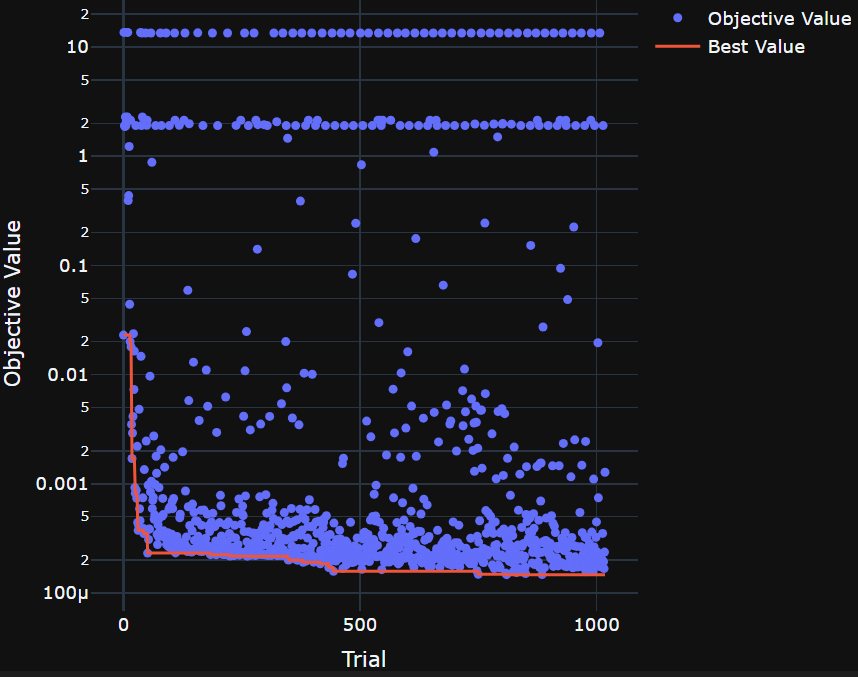

In [44]:
from IPython.display import Image
Image(filename='../images/en_trials.png', height=200, width=700)

Percebe-se que o trial 810 foi o melhor e analisando-se os resultados até ele, o RMSE não deve aumentar significativamente mais.

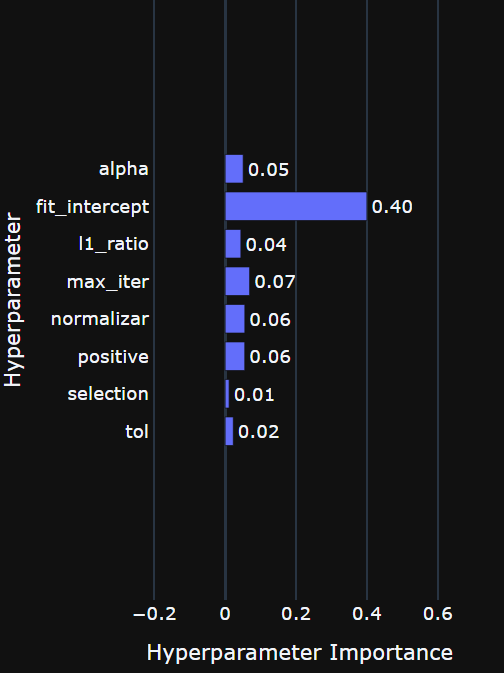

In [37]:
Image(filename='../images/en_parameters.png', width=300)

Vê-se que o fit_intercept foi o parâmetro significativamente mais importante. Selection tem importância tendendo a zero, como era de se esperar.

Para o trial de melhor resultado, os parâmetros eram:

Trial 810 finished with value: 0.00014746162905534939 and parameters: {'alpha': 0.00006820706258709369, 'l1_ratio': 0.17332460629146462, 'fit_intercept': True, 'positive': False, 'max_iter': 33778, 'tol': 8.423671561653807e-7, 'selection': 'random', 'normalizar': 'rfe', 'rfe_features': 31}.

O resultado é muito promissor,com primeiro algarismo na quarta casa após a vírgula sendo 1. O RMSE é muito baixo, sendo possível ótima correção dos cálculos do xtb usando-se do ElasticNet.

### 4. Interpretabilidade via SHAP

#### 4.1 O que é o *SHAP*

![image](https://shap.readthedocs.io/en/latest/_images/shap_header.png)

**Fonte:** [SHAP](https://shap.readthedocs.io/en/latest/)

O *SHAP (SHapley Additive exPlanations)* é uma abordagem baseada em teoria dos jogos para explicar a saída de qualquer modelo de aprendizado de máquina (“black-box”). 

O conceito central deriva dos valores de `Lloyd Shapley (Shapley values)`, originalmente desenvolvidos em jogos cooperativos, para distribuir “créditos” aos jogadores conforme suas contribuições marginais.

No contexto de modelos de ML, cada “jogador” é um *feature* (variável) ou valor de feature, e o “prêmio” do jogo é o valor de predição do modelo menos um valor de referência (por exemplo, a média da predição). 

#### 4.2 Relação com a interpretabilidade de modelos

Em muitos cenários de aprendizado de máquina, especialmente em modelos de alta complexidade (como ensembles, redes neurais…), temos alta acurácia mas baixa transparência (“caixa-preta”). SHAP ajuda a reduzir essa lacuna ao oferecer explicações compreensíveis para as previsões. Permite responder perguntas como: *Quais features mais contribuíram para esta previsão?* ou *Para um dado cliente, quais variáveis “empurraram” a predição para cima ou para baixo?*

Pode também ajudar na visão global do modelo: agregando valores SHAP sobre muitas instâncias, conseguimos visualizar quais features têm geralmente mais impacto nas previsões, detectar dependências ou interações, e até investigar vieses ou decisões inesperadas.

**Como funciona em termos gerais**  
1. Para uma dada instância de entrada $x$, o modelo prediz $f(x)$.  
2. A ideia é computar quanto cada feature contribui para essa predição, comparada à previsão média $\mathbb{E}[f(X)]$.  
3. Para cada feature $j$, consideram-se todas (ou muitas) as combinações possíveis de features que a precedem (coalitions). Para cada coalizão $S \subseteq \{1, \dots, p\} \setminus \{j\}$, mede-se a “valoração” $v(S \cup \{j\}) - v(S)$ — ou seja, a diferença de predição se incluirmos $j$ ou não. A média desta diferença (ponderada apropriadamente) dá o valor SHAP $\phi_j$.  
4. As contribuições $\phi_j$ de todas as features somam-se exatamente à diferença $f(x) - \mathbb{E}[f(X)]$. Essa é a propriedade de **eficiência**.  

**Propriedades importantes que tornam SHAP útil para interpretabilidade**  

- **Localidade**: SHAP explica *uma predição individual* (instância $x$), o que é muito relevante quando queremos entender “por que esse cliente foi aceito ou recusado?”.
  
- **Aditividade / Eficiência**: A soma das contribuições das features corresponde à diferença entre a predição e o valor médio, garantindo que nenhuma “parte” da explicação se perca.   
  
- **Consistência**: Em teoria, se o modelo altera-se de modo que a contribuição de um feature aumente, então seu valor SHAP não diminui — isso faz com que a explicação seja “justa” em termos de atribuição.  
  
- **Modelo-agnóstico (até certo ponto)**: SHAP pode ser aplicado a muitos tipos de modelos (regressão, árvores de decisão, redes neurais…) porque trata das features como “jogadores” sem depender fortemente da estrutura do modelo. 

### 5. Usando o SHAP

#### 5.1 Módulo necessário

Antes de tudo, certifique-se de ter instalado o módulo `shap`.

---

````python
pip install shap
````
---

In [7]:
import shap

#### 5.2 Avaliando o melhor modelo

Para analisar a interpretabilidade do modelo vencedor encontrado pelo *Optuna*, precisamos carregá-lo a partir do arquivo de estudo utilizando a função `load_study`.

**Observação importante:** O *SHAP* não aceita um pipeline completo como entrada, ele requer um modelo final ou uma função de predição. Por isso, criamos um *trial* “falso” (`FixedTrial`) com os melhores hiperparâmetros para instanciar o pipeline vencedor.

Além disso, o modelo não é definido apenas pelos hiperparâmetros do algoritmo (`ElasticNet`), mas também inclui todas as etapas de pré-processamento do pipeline, como `StandardScaler`, `RFE`, `PCA` ou `VarianceThreshold`. Essas transformações devem ser aplicadas corretamente antes de calcular os valores de SHAP, garantindo que a explicação reflita exatamente como o modelo processa os dados.


In [15]:
# --- Carregar estudo Optuna ---
NOME_DO_ESTUDO = "elasticnet_xtb"
study = load_study(study_name=NOME_DO_ESTUDO, storage=f"sqlite:///{NOME_DO_ESTUDO}.db")

# --- Recuperar melhores parâmetros ---
melhores_params = study.best_trial.params
fake_trial = trial.FixedTrial(melhores_params)

# --- Instanciar modelo conforme melhores parâmetros ---
melhor_modelo = inst_elasticnet(fake_trial)

# --- Treinar o modelo ---
melhor_modelo.fit(X_train, y_train)

# --- Identificar quais steps o pipeline possui ---
steps = [name for name, _ in melhor_modelo.named_steps.items()] if hasattr(melhor_modelo, "named_steps") else []

# --- Obter representações transformadas de X_train e X_test ---
X_train_transf, X_test_transf = X_train, X_test

if "standardscaler" in steps:
    scaler = melhor_modelo.named_steps["standardscaler"]
    X_train_transf = scaler.transform(X_train_transf)
    X_test_transf = scaler.transform(X_test_transf)

if "variancethreshold" in steps:
    var_th = melhor_modelo.named_steps["variancethreshold"]
    X_train_transf = var_th.transform(X_train_transf)
    X_test_transf = var_th.transform(X_test_transf)

if "pca" in steps:
    pca = melhor_modelo.named_steps["pca"]
    X_train_transf = pca.transform(X_train_transf)
    X_test_transf = pca.transform(X_test_transf)

if "rfe" in steps:
    rfe = melhor_modelo.named_steps["rfe"]
    X_train_transf = rfe.transform(X_train_transf)
    X_test_transf = rfe.transform(X_test_transf)
    selected_features = X_train.columns[rfe.get_support()]
else:
    # Caso não tenha RFE nem PCA, usamos as colunas originais
    selected_features = getattr(X_train, "columns", [f"feat_{i}" for i in range(X_train.shape[1])])

# --- Identificar o modelo final (ElasticNet) ---
if hasattr(melhor_modelo, "named_steps"):
    modelo_final = melhor_modelo.named_steps["elasticnet"]
else:
    modelo_final = melhor_modelo

# --- Calcular explicações SHAP ---
explainer = shap.LinearExplainer(modelo_final, X_train_transf)
shap_values = explainer.shap_values(X_test_transf)

c:\Users\edelio25024\OneDrive - ILUM ESCOLA DE CIÊNCIA\VSCODE\R2D2_MACHINE_LEARNING\R2D2\.venv\Lib\site-packages\sklearn\feature_selection\_rfe.py:300: UserWarning: Found n_features_to_select=31 > n_features=9. There will be no feature selection and all features will be kept.
  warnings.warn(
c:\Users\edelio25024\OneDrive - ILUM ESCOLA DE CIÊNCIA\VSCODE\R2D2_MACHINE_LEARNING\R2D2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.229e-01, tolerance: 1.481e-01
  model = cd_fast.enet_coordinate_descent(


---

Agora podemos *plotar* alguns gráficos!

---

#### 5.3 Summary Plot 

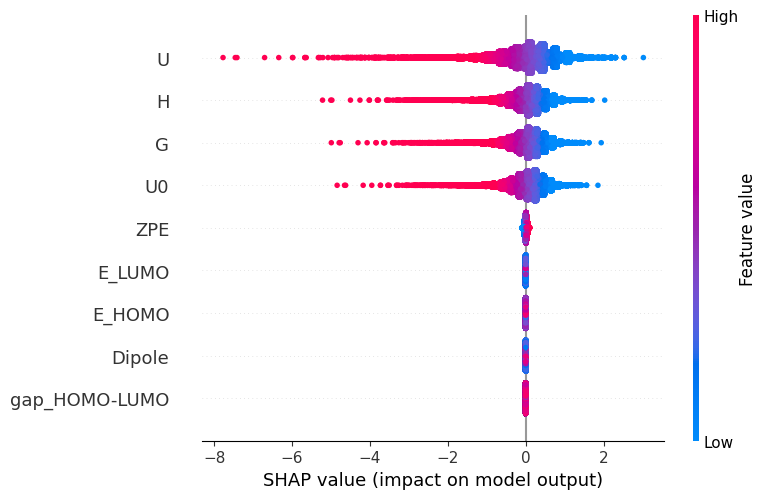

In [16]:
# --- Plotar resumo SHAP ---
shap.summary_plot(shap_values, X_test_transf, feature_names=selected_features)

O gráfico acima é um **summary plot** do SHAP, mostrando a importância e direção do efeito de cada feature sobre as predições do modelo ElasticNet.

`Observações principais`:

1. **Features mais importantes:**  
   As variáveis `H`, `U`, `G` e `U0` apresentam os maiores valores absolutos de SHAP, indicando que são as que mais influenciam a saída do modelo.  

2. **Direção do efeito:**  
   - Pontos à esquerda (SHAP negativo) indicam que **aumentar o valor da feature reduz a predição**.  
   - Pontos à direita (SHAP positivo) indicam que **aumentar a feature aumenta a predição**.

3. **Cor das observações:**  
   - Tons mais **vermelhos** representam valores altos da feature.  
   - Tons mais **azuis** representam valores baixos da feature.  
   Assim, podemos ver como a magnitude da feature está correlacionada com a direção do efeito no modelo. Por exemplo:
   - Para `H`, valores altos (vermelhos) tendem a empurrar a predição para valores negativos, indicando efeito contrário ao alvo.  
   - Para `U`, valores altos também reduzem a predição, seguindo padrão similar.  

4. **Features menos relevantes:**  
   `ZPE`, `E_LUMO`, `E_HOMO`, `Dipole` e `gap_HOMO-LUMO` têm SHAP próximo de zero, mostrando que **essas variáveis têm pouca influência** sobre o modelo.  

Assim, podemos conclui que modelo parece depender fortemente de um **pequeno subconjunto de variáveis** (H, U, G, U0), enquanto outras features contribuem pouco.

Vamos confirmar isso fazendo uma nova previsão, mas somente com as *features* que o *SHAP* inidcou como mais relevantes.

In [9]:
model = ElasticNet(alpha=0.00006820706258709369,
                   l1_ratio=0.17332460629146462, 
                   fit_intercept=True, 
                   positive=False,
                   max_iter=33778,
                   tol=8.423671561653807e-7,
                   selection='random')

pipe_final = make_pipeline(
    StandardScaler(), 
    RFE(estimator=RandomForestRegressor(), n_features_to_select=31),
    model
)

cv = KFold(n_splits=10, shuffle=True, random_state=27)
cv_rf = -cross_val_score(
    RandomForestRegressor(),
    X_test[['H', 'U', 'G', 'U0']],
    y_test,
    cv=cv,
    scoring='neg_root_mean_squared_error'
)

print(f'RMSE Médio (CV) - Random Forest: {cv_rf.mean()}')


RMSE Médio (CV) - Random Forest: 0.0056708125304546055


Observe que ao mantermos as *features* de maior importância o desempenho melhorou em $\approx 28,63\%$

#### 5.4 Bar Plot

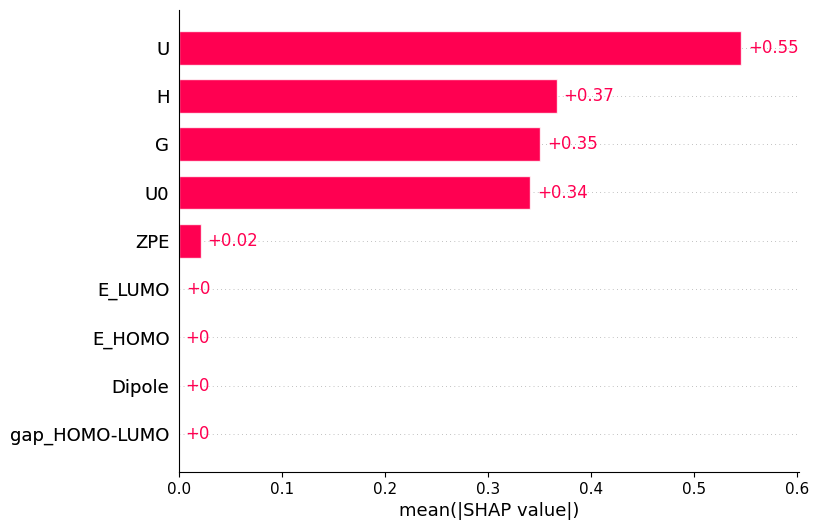

In [17]:
shap_values_exp = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test,
    feature_names=X_test.columns
)

shap.plots.bar(shap_values_exp)

O gráfico de barras apresenta a **importância global das variáveis** de acordo com o valor médio absoluto dos *SHAP values*.  
Ele indica, em média, **quanto cada variável contribui para alterar as previsões do modelo** — independentemente de aumentar ou diminuir o valor predito.

- O eixo horizontal mostra o valor médio de $|SHAP|$, ou seja, a **intensidade média do impacto**.  
- As variáveis são ordenadas de forma decrescente, destacando as que mais influenciam o modelo.  
- Valores próximos de zero indicam que a *feature* tem pouca ou nenhuma influência sobre as previsões.

**Interpretação:**  
O que foi mostrada no *summary plot* é apenas reforçado aqui, mas de forma mais quantitativa.


#### 5.5 Waterfall Plot

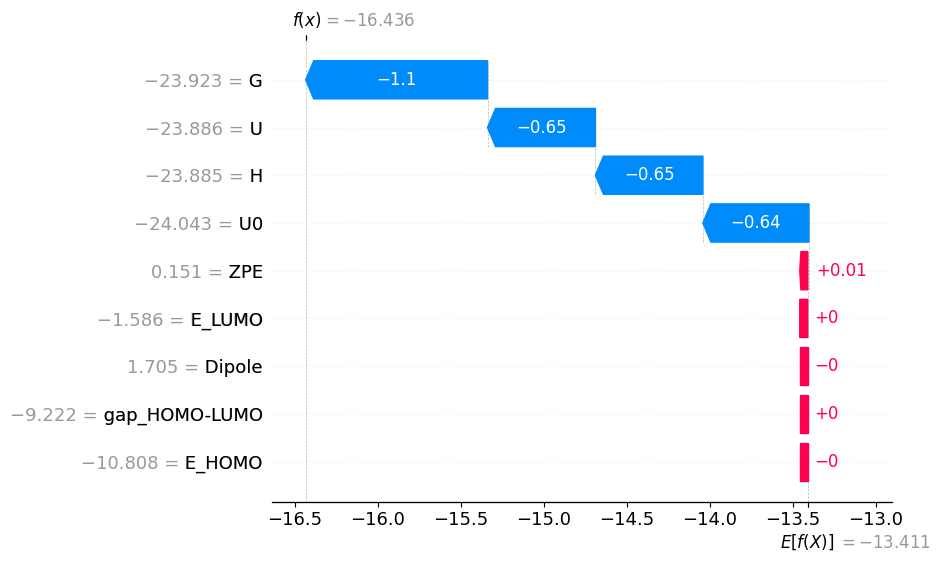

In [ ]:
shap.plots.waterfall(shap_values_exp[0])

O gráfico *waterfall* detalha **como cada variável contribuiu para uma predição específica** do modelo.  
Partindo da média global das predições $E[f(X)]$, o gráfico mostra passo a passo o efeito de cada *feature* até chegar ao valor final $f(x)$ da amostra analisada.

- As **barras azuis** indicam *features* que **reduzem** a previsão (impacto negativo).  
- As **barras vermelhas** representam *features* que **aumentam** a previsão (impacto positivo).  
- À esquerda, vê-se o valor médio da variável na amostra e sua respectiva contribuição.

**Interpretação:**  
Para essa instância, as variáveis **G**, **U**, **H** e **U0** têm forte influência negativa, reduzindo o valor final previsto ($f(x) = -16.436$).  
Já as demais variáveis têm impacto quase nulo.  
Assim, o gráfico mostra **como a combinação específica dos valores dessas variáveis levou o modelo a fazer essa predição em particular**, revelando a **explicabilidade local** do modelo.

### 5. Referências
DATACAMP. Tutorial: Regressão Lasso e Ridge no Python. 2025. Disponível em: https://www.datacamp.com/pt/tutorial/tutorial-lasso-ridge-regression. Acesso em: 27 set. 2025.

PEDREGOSA, F. et al. sklearn.linear_model.ElasticNet. Scikit-learn, 2025. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html. Acesso em: 27 set. 2025.

THE PANDAS DEVELOPMENT TEAM. pandas.DataFrame.drop. Pandas, 2025. Disponível em: https://pandas.pydata-org.translate.goog/docs/reference/api/pandas.DataFrame.drop.html?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt&_x_tr_pto=tc. Acesso em: 27 set. 2025.

ZINI, Fernando. Regressão Linear: Teoria e Prática. YouTube, 10 set. 2023. Disponível em: https://www.youtube.com/watch?v=VqKq78PVO9g. Acesso em: 27 set. 2025.

PEDREGOSA, F. et al. 1.1. Linear Models. Scikit-learn, 2025. Disponível em: https://scikit-learn.org/stable/modules/linear_model.html. Acesso em: 27 set. 2025.

DeepSeek. Disponível em: https://chat.deepseek.com/share/j7z37nakhld1e4jftp. Acesso em: 27 set. 2025.

KAGGLE. Student Academic Performance Trends Dataset. 2024. Disponível em: https://www.kaggle.com/datasets/emanfatima2025/student-academic-performance-trends Acesso em: 27 set. 2025.

LIGEIRO, Gabriel. Como interpretar seu modelo de machine learning usando SHAP values. Medium, 5 dez. 2020. Disponível em: https://gabrielligeiro.medium.com/como-interpretar-seu-modelo-de-machine-learning-usando-shap-values-2c61c0d26317
. Acesso em: 24 out. 2025.

LUNDBERG, Scott; LEE, Su-In. SHAP – Welcome to the SHAP documentation. 2018 (?). Disponível em: https://shap.readthedocs.io/en/latest/
. Acesso em: 24 out. 2025.

AWAN, Abid Ali. Uma introdução aos valores SHAP e à interpretabilidade do aprendizado de máquina. DataCamp, 11 set. 2024. Disponível em: https://www.datacamp.com/pt/tutorial/introduction-to-shap-values-machine-learning-interpretability
. Acesso em: 24 out. 2025.

Modelos 3, 2025. Silveira Matheus. Acesso em: 25 out. 2025.

Modelos 7, 2025. Neto Aniel et al. Acesso em: 25 set. 2025.

Modelos 6, 2025. Mendes Mateus et al. Acesso em: 25 out. 2025.